# Document Re-Ranking with Random Forest

**Part 1:** BM25 baseline retrieval + training data generation  
**Part 2:** Random Forest re-ranking model + evaluation

In [1]:
# Imports
import os, json, re, pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Semantic similarity imports
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# LlamaIndex imports for BM25
from llama_index import SimpleDirectoryReader
from llama_index.node_parser import SimpleNodeParser
from llama_index.readers.base import BaseReader
from llama_index.schema import Document
from pathlib import Path
from typing import Dict, List, Optional

In [3]:
# Configuration
DATA_PATH = 'data/qas_v2_clean.json'
DOCS_PATH = 'data/retrieval_base/gt'
OUTPUT_PATH = 'output'
CHUNK_SIZE = 1024
CHUNK_OVERLAP = 0
CANDIDATE_K = 5    # BM25 candidates for reranking
FINAL_K = 2         # Final docs returned
TEST_SPLIT = 0.3

os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(f'{OUTPUT_PATH}/model', exist_ok=True)

---
## Part 1: BM25 Baseline Retrieval

In [4]:
# JSON Reader for document corpus
class PCJSONReader(BaseReader):
    def load_data(self, file: Path, extra_info: Optional[Dict] = None) -> List[Document]:
        documents = []
        with open(file, encoding='utf-8') as f:
            for data in json.load(f):
                documents.append(Document(
                    text=data['text'],
                    metadata={'page_idx': data.get('page_idx', data.get('page_no')), **extra_info}
                ))
        return documents

# BM25 Retriever (builds index per domain)
class BM25Retriever:
    def __init__(self, docs_dir, chunk_size=1024, chunk_overlap=0, top_k=2):
        self.top_k = top_k
        self.retrievers = {}
        parser = SimpleNodeParser.from_defaults(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        
        domains = [d for d in os.listdir(docs_dir) if os.path.isdir(os.path.join(docs_dir, d))]
        for domain in tqdm(domains, desc="Indexing domains"):
            domain_path = os.path.join(docs_dir, domain)
            docs = SimpleDirectoryReader(
                domain_path, file_extractor={".json": PCJSONReader()},
                recursive=True, required_exts=[".json"]
            ).load_data()
            nodes = parser.get_nodes_from_documents(docs, show_progress=True)
            from llama_index.retrievers import BM25Retriever as LlamaBM25
            self.retrievers[domain] = LlamaBM25.from_defaults(nodes=nodes, similarity_top_k=top_k)
        print("Done!")
    
    def search(self, query_text, domain, top_k=None):
        k = top_k or self.top_k
        retriever = self.retrievers.get(domain)
        if not retriever: return []
        retriever._similarity_top_k = k
        return [{
            'text': n.get_content(),
            'page_idx': n.metadata.get('page_idx'),
            'file_name': n.metadata.get('file_name', '').replace('.json', '')
        } for n in retriever.retrieve(query_text)]

In [5]:
# Load QA data
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    qa_data = json.load(f)
print(f"Loaded {len(qa_data)} queries")

Loaded 7481 queries


In [7]:
# Build BM25 index
bm25 = BM25Retriever(DOCS_PATH, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP, top_k=CANDIDATE_K)

Indexing domains: 100%|██████████| 9/9 [01:38<00:00, 10.93s/it]

Done!


In [8]:
# Initialize MiniLM embedding model for semantic similarity
print("Loading MiniLM-L6-v2 embedding model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print("Embedding model loaded!")

# Cache for precomputed document embeddings
doc_embedding_cache = {}

def get_doc_embedding(doc_text):
    """Get document embedding with caching."""
    doc_hash = hash(doc_text[:500])  # Use first 500 chars as hash key
    if doc_hash not in doc_embedding_cache:
        doc_embedding_cache[doc_hash] = embedding_model.encode(doc_text, convert_to_numpy=True)
    return doc_embedding_cache[doc_hash]

def compute_semantic_similarity(query, doc_text):
    """Compute cosine similarity between query and document using MiniLM embeddings."""
    query_embedding = embedding_model.encode(query, convert_to_numpy=True)
    doc_embedding = get_doc_embedding(doc_text)
    
    # Compute cosine similarity
    similarity = cosine_similarity(
        query_embedding.reshape(1, -1), 
        doc_embedding.reshape(1, -1)
    )[0][0]
    
    return float(similarity)

print(f"Semantic similarity function ready. Cache size: {len(doc_embedding_cache)}")

Loading MiniLM-L6-v2 embedding model...
Embedding model loaded!
Semantic similarity function ready. Cache size: 0


In [9]:
# Metric: LCS Score
def normalize(s):
    import string
    s = s.lower()
    s = re.sub(r"\b(a|an|the)\b", " ", s)
    s = ''.join(c for c in s if c not in string.punctuation)
    return ' '.join(s.split())

def lcs_score(pred, gt):
    A, B = normalize(gt).split(), normalize(pred).split()
    if not A: return 0.5
    dp = [[0]*(len(B)+1) for _ in range(len(A)+1)]
    for i in range(1, len(A)+1):
        for j in range(1, len(B)+1):
            dp[i][j] = dp[i-1][j-1]+1 if A[i-1]==B[j-1] else max(dp[i-1][j], dp[i][j-1])
    return dp[len(A)][len(B)] / len(A)

In [10]:
# Feature extraction for reranking (Enhanced with 25 features)
import math
from collections import Counter

def get_words(text): return re.findall(r'\b\w+\b', text.lower())
def get_ngrams(words, n): return set(zip(*[words[i:] for i in range(n)]))

# Global IDF computation (computed once from corpus approximation)
def compute_idf(doc_words_list):
    """Compute IDF scores from a list of document word sets."""
    N = len(doc_words_list)
    df = Counter()
    for doc_words in doc_words_list:
        for w in set(doc_words):
            df[w] += 1
    return {w: math.log((N + 1) / (freq + 1)) + 1 for w, freq in df.items()}

# Simple IDF approximation using document length as proxy
def approx_idf(word, doc_words):
    """Approximate IDF - rarer terms in document get higher score."""
    freq = doc_words.count(word)
    if freq == 0:
        return 3.0  # High IDF for missing terms
    return max(0.5, math.log(len(doc_words) / (freq + 1)) + 1)

def find_query_term_positions(q_words, d_words):
    """Find all positions where query terms appear in document."""
    positions = {}
    for qw in set(q_words):
        positions[qw] = [i for i, dw in enumerate(d_words) if dw == qw]
    return positions

def compute_window_features(q_words, d_words, positions):
    """Compute sliding window based features."""
    if not q_words or not d_words:
        return {
            'min_query_coverage_window': 0,
            'best_window_match_density': 0,
            'first_complete_match_position': 1.0,
            'multi_window_coverage_count': 0
        }
    
    q_set = set(q_words)
    doc_len = len(d_words)
    window_size = min(len(q_words) * 3, doc_len)  # Adaptive window size
    
    best_coverage = 0
    best_density = 0
    first_complete_pos = doc_len
    complete_windows = 0
    
    for start in range(0, max(1, doc_len - window_size + 1), max(1, window_size // 2)):
        end = min(start + window_size, doc_len)
        window = d_words[start:end]
        window_set = set(window)
        
        matched = q_set & window_set
        coverage = len(matched) / len(q_set) if q_set else 0
        density = len(matched) / len(window) if window else 0
        
        if coverage > best_coverage:
            best_coverage = coverage
        if density > best_density:
            best_density = density
        
        if coverage >= 0.9:  # Near-complete match
            complete_windows += 1
            if start < first_complete_pos:
                first_complete_pos = start
    
    return {
        'min_query_coverage_window': best_coverage,
        'best_window_match_density': best_density,
        'first_complete_match_position': 1 - (first_complete_pos / doc_len) if doc_len > 0 else 0,
        'multi_window_coverage_count': min(complete_windows / 5, 1.0)  # Normalize
    }

def compute_distance_features(q_words, d_words, positions):
    """Compute query term distance and compactness features."""
    if not q_words or not d_words:
        return {
            'avg_query_term_distance': 1.0,
            'query_term_distance_variance': 1.0,
            'query_compactness_gain': 0,
            'match_span_compression_ratio': 0
        }
    
    q_set = set(q_words)
    matched_positions = []
    for qw in q_set:
        if qw in positions and positions[qw]:
            matched_positions.extend(positions[qw])
    
    if len(matched_positions) < 2:
        return {
            'avg_query_term_distance': 0.5,
            'query_term_distance_variance': 0.5,
            'query_compactness_gain': 0.5 if matched_positions else 0,
            'match_span_compression_ratio': 0.5 if matched_positions else 0
        }
    
    matched_positions = sorted(matched_positions)
    distances = [matched_positions[i+1] - matched_positions[i] for i in range(len(matched_positions)-1)]
    
    avg_dist = np.mean(distances) if distances else 0
    var_dist = np.var(distances) if distances else 0
    
    span = matched_positions[-1] - matched_positions[0] + 1
    expected_span = len(d_words)
    compression = 1 - (span / expected_span) if expected_span > 0 else 0
    
    # Compactness gain: how much better than random distribution
    random_expected_dist = len(d_words) / (len(matched_positions) + 1)
    compactness_gain = 1 - (avg_dist / random_expected_dist) if random_expected_dist > 0 else 0
    
    return {
        'avg_query_term_distance': 1 - min(avg_dist / 100, 1.0),  # Normalize and invert
        'query_term_distance_variance': 1 - min(var_dist / 1000, 1.0),  # Lower variance = better
        'query_compactness_gain': max(0, compactness_gain),
        'match_span_compression_ratio': max(0, compression)
    }

def compute_idf_features(q_words, d_words, positions):
    """Compute IDF-weighted features."""
    if not q_words or not d_words:
        return {
            'avg_idf_matched_terms': 0,
            'max_idf_term_presence': 0,
            'idf_weighted_window_density': 0
        }
    
    q_set = set(q_words)
    d_set = set(d_words)
    common = q_set & d_set
    
    # Compute IDF for query terms
    idf_scores = {w: approx_idf(w, d_words) for w in q_set}
    
    if not common:
        return {
            'avg_idf_matched_terms': 0,
            'max_idf_term_presence': 0,
            'idf_weighted_window_density': 0
        }
    
    # Average IDF of matched terms
    matched_idfs = [idf_scores[w] for w in common]
    avg_idf = np.mean(matched_idfs)
    max_idf = max(matched_idfs)
    
    # IDF-weighted density
    total_idf = sum(idf_scores.values())
    matched_idf_sum = sum(idf_scores[w] for w in common)
    idf_weighted_density = matched_idf_sum / total_idf if total_idf > 0 else 0
    
    # Normalize to 0-1 range
    return {
        'avg_idf_matched_terms': min(avg_idf / 5, 1.0),
        'max_idf_term_presence': min(max_idf / 5, 1.0),
        'idf_weighted_window_density': idf_weighted_density
    }

def compute_advanced_features(query, doc, rank, q_words, d_words):
    """Compute additional advanced features."""
    q_set = set(q_words)
    d_set = set(d_words)
    common = q_set & d_set
    
    # Length normalized match strength
    coverage = len(common) / len(q_set) if q_set else 0
    length_factor = min(len(d_words) / 500, 2.0)  # Penalize very long docs
    length_norm_strength = coverage / length_factor if length_factor > 0 else coverage
    
    # Answer likeness score (short, informative chunks score higher)
    ideal_answer_len = 100  # Approximate ideal answer length
    len_diff = abs(len(d_words) - ideal_answer_len)
    answer_likeness = max(0, 1 - len_diff / 500) * coverage
    
    # Near exact phrase density (consecutive matching words)
    phrase_matches = 0
    for i in range(len(d_words) - 1):
        if d_words[i] in q_set and d_words[i+1] in q_set:
            phrase_matches += 1
    near_exact_phrase_density = phrase_matches / max(len(q_words) - 1, 1) if len(q_words) > 1 else 0
    
    # Rank confidence ratio (how confident should we be based on rank position)
    rank_confidence = 1.0 / (1 + rank * 0.5)  # Decay based on rank
    
    return {
        'length_normalized_match_strength': min(length_norm_strength, 1.0),
        'answer_likeness_score': min(answer_likeness, 1.0),
        'near_exact_phrase_density': min(near_exact_phrase_density, 1.0),
        'rank_confidence_ratio': rank_confidence
    }

def extract_features(query, doc, rank):
    """Extract all 26 features for query-document pair (including semantic similarity)."""
    q_words, d_words = get_words(query), get_words(doc)
    q_set, d_set = set(q_words), set(d_words)
    common = q_set & d_set
    
    q_bi, d_bi = get_ngrams(q_words, 2), get_ngrams(d_words, 2)
    q_tri, d_tri = get_ngrams(q_words, 3), get_ngrams(d_words, 3)
    
    # Original 10 features
    base_features = [
        len(common)/len(q_set) if q_set else 0,                    # query_coverage
        len(common)/len(q_set|d_set) if q_set|d_set else 0,        # word_overlap
        len(q_bi&d_bi)/len(q_bi) if q_bi else 0,                   # bigram_overlap
        len(q_tri&d_tri)/len(q_tri) if q_tri else 0,               # trigram_overlap
        1.0 if query.lower() in doc.lower() else 0.0,              # exact_match
        sum(d_words.count(w) for w in q_set)/len(d_words) if d_words else 0,  # term_freq
        len(q_set&set(d_words[:50]))/len(q_set) if q_set else 0,   # early_match
        min(len(d_words)/500, 1.0),                                # doc_len_norm
        len(q_words)/len(d_words) if d_words else 0,               # query_doc_ratio
        1.0/(rank+1),                                              # bm25_rank_score
    ]
    
    # Compute positions for advanced features
    positions = find_query_term_positions(q_words, d_words)
    
    # New features (15 additional)
    window_feats = compute_window_features(q_words, d_words, positions)
    distance_feats = compute_distance_features(q_words, d_words, positions)
    idf_feats = compute_idf_features(q_words, d_words, positions)
    advanced_feats = compute_advanced_features(query, doc, rank, q_words, d_words)
    
    # Combine all new features in order
    new_features = [
        window_feats['min_query_coverage_window'],        # 11
        distance_feats['query_compactness_gain'],         # 12
        window_feats['best_window_match_density'],        # 13
        distance_feats['avg_query_term_distance'],        # 14
        distance_feats['query_term_distance_variance'],   # 15
        window_feats['first_complete_match_position'],    # 16
        distance_feats['match_span_compression_ratio'],   # 17
        idf_feats['avg_idf_matched_terms'],               # 18
        idf_feats['max_idf_term_presence'],               # 19
        idf_feats['idf_weighted_window_density'],         # 20
        advanced_feats['length_normalized_match_strength'],# 21
        advanced_feats['answer_likeness_score'],          # 22
        window_feats['multi_window_coverage_count'],      # 23
        advanced_feats['near_exact_phrase_density'],      # 24
        advanced_feats['rank_confidence_ratio'],          # 25
    ]
    
    # Semantic similarity feature (26th feature)
    semantic_sim = compute_semantic_similarity(query, doc)
    
    return base_features + new_features + [semantic_sim]

# All 26 feature names (including semantic_similarity)
FEATURE_NAMES = [
    # Original 10 features
    'query_coverage', 'word_overlap', 'bigram_overlap', 'trigram_overlap',
    'exact_match', 'term_freq', 'early_match', 'doc_len_norm', 'query_doc_ratio', 'bm25_rank',
    # New 15 features
    'min_query_coverage_window', 'query_compactness_gain', 'best_window_match_density',
    'avg_query_term_distance', 'query_term_distance_variance', 'first_complete_match_position',
    'match_span_compression_ratio', 'avg_idf_matched_terms', 'max_idf_term_presence',
    'idf_weighted_window_density', 'length_normalized_match_strength', 'answer_likeness_score',
    'multi_window_coverage_count', 'near_exact_phrase_density', 'rank_confidence_ratio',
    # Semantic similarity feature (MiniLM embeddings)
    'semantic_similarity'
]

print(f"Total features: {len(FEATURE_NAMES)}")

Total features: 26


In [11]:
# Build training data (Enhanced with 26 features including semantic similarity)
TRAINING_DATA_PATH = f'{OUTPUT_PATH}/training_data_enhanced_semantic.csv'

def build_training_data():
    X, y, info = [], [], []
    for item in tqdm(qa_data, desc="Building training data"):
        query = item['questions']
        domain = item['doc_name'].split('/')[0]
        correct_doc = '/'.join(item['doc_name'].split('/')[1:])
        correct_pages = item['evidence_page_no']
        if not isinstance(correct_pages, list): correct_pages = [correct_pages]
        correct_pages = set(correct_pages)
        
        gt_text = item['evidence_context']
        if isinstance(gt_text, list): gt_text = '\n'.join(gt_text)
        
        candidates = bm25.search(query, domain, top_k=CANDIDATE_K)
        if not candidates: continue
        
        for rank, doc in enumerate(candidates):
            is_correct = doc.get('file_name')==correct_doc and doc.get('page_idx') in correct_pages
            text_overlap = lcs_score(doc['text'], gt_text) if gt_text else 0
            label = 1 if (is_correct or text_overlap > 0.3) else 0
            
            X.append(extract_features(query, doc['text'], rank))
            y.append(label)
            info.append({'query_id': item['ID'], 'doc_type': domain})
    
    return np.array(X), np.array(y), info

print(f"Training data path: {TRAINING_DATA_PATH}")
print(f"Features ({len(FEATURE_NAMES)}): {FEATURE_NAMES}")

Training data path: output/training_data_enhanced_semantic.csv
Features (26): ['query_coverage', 'word_overlap', 'bigram_overlap', 'trigram_overlap', 'exact_match', 'term_freq', 'early_match', 'doc_len_norm', 'query_doc_ratio', 'bm25_rank', 'min_query_coverage_window', 'query_compactness_gain', 'best_window_match_density', 'avg_query_term_distance', 'query_term_distance_variance', 'first_complete_match_position', 'match_span_compression_ratio', 'avg_idf_matched_terms', 'max_idf_term_presence', 'idf_weighted_window_density', 'length_normalized_match_strength', 'answer_likeness_score', 'multi_window_coverage_count', 'near_exact_phrase_density', 'rank_confidence_ratio', 'semantic_similarity']


In [13]:
# Generate and save enhanced training data
FORCE_REGENERATE = False

if FORCE_REGENERATE or not os.path.exists(TRAINING_DATA_PATH):
    print(f"Generating enhanced training data with {len(FEATURE_NAMES)} features...")
    X, y, info = build_training_data()
    df = pd.DataFrame(X, columns=FEATURE_NAMES)
    df['label'] = y
    df['query_id'] = [i['query_id'] for i in info]
    df['doc_type'] = [i['doc_type'] for i in info]
    df.to_csv(TRAINING_DATA_PATH, index=False)
    print(f"Saved {len(df)} samples with {len(FEATURE_NAMES)} features to {TRAINING_DATA_PATH}")
else:
    print(f"Training data already exists at {TRAINING_DATA_PATH}")

Training data already exists at output/training_data_enhanced_semantic.csv


In [14]:
# Evaluation function
def evaluate(retriever_fn, qa_list, top_k=FINAL_K):
    scores = []
    for item in tqdm(qa_list, desc="Evaluating"):
        domain = item['doc_name'].split('/')[0]
        correct_doc = '/'.join(item['doc_name'].split('/')[1:])
        correct_pages = set(item['evidence_page_no'] if isinstance(item['evidence_page_no'], list) else [item['evidence_page_no']])
        gt_text = item['evidence_context']
        if isinstance(gt_text, list): gt_text = '\n'.join(gt_text)
        
        results = retriever_fn(item['questions'], domain, top_k)
        matched = [r['text'] for r in results if r.get('file_name')==correct_doc and r.get('page_idx') in correct_pages]
        scores.append(lcs_score('\n'.join(matched), gt_text) if matched and gt_text else 0.0)
    return np.mean(scores)

In [15]:
# BM25 Baseline evaluation
print("Evaluating BM25 baseline...")
bm25_results = []
for item in tqdm(qa_data, desc="Evaluating"):
    domain = item['doc_name'].split('/')[0]
    evidence_source = item.get('evidence_source', '')
    correct_doc = '/'.join(item['doc_name'].split('/')[1:])
    correct_pages = set(item['evidence_page_no'] if isinstance(item['evidence_page_no'], list) else [item['evidence_page_no']])
    gt_text = item['evidence_context']
    if isinstance(gt_text, list): gt_text = '\n'.join(gt_text)
    
    results = bm25.search(item['questions'], domain, top_k=FINAL_K)
    matched = [r['text'] for r in results if r.get('file_name')==correct_doc and r.get('page_idx') in correct_pages]
    score = lcs_score('\n'.join(matched), gt_text) if matched and gt_text else 0.0
    bm25_results.append({'score': score, 'domain': domain, 'evidence_source': evidence_source, 'query_id': item['ID']})

bm25_df = pd.DataFrame(bm25_results)
bm25_df.to_csv(f'{OUTPUT_PATH}/bm25_baseline_scores.csv', index=False)
baseline_score = bm25_df['score'].mean()
print(f"\nBM25 Baseline LCS Score: {baseline_score:.4f}")
print(f"Saved to {OUTPUT_PATH}/bm25_baseline_scores.csv")

Evaluating BM25 baseline...


Evaluating: 100%|██████████| 7481/7481 [04:41<00:00, 26.61it/s] 



BM25 Baseline LCS Score: 0.8034
Saved to output/bm25_baseline_scores.csv


In [17]:
# BM25 Results by Domain and Evidence Source
bm25_df['lcs_percent'] = bm25_df['score'] * 100

print("Results by Domain:")
domain_summary = bm25_df.groupby('domain').agg({
    'lcs_percent': ['mean', 'count']
}).round(2)
display(domain_summary)

print("\nResults by Evidence Source:")
evidence_summary = bm25_df.groupby('evidence_source').agg({
    'lcs_percent': ['mean', 'count']
}).round(2)
display(evidence_summary)

print(f"\nOverall Average LCS: {bm25_df['lcs_percent'].mean():.2f}%")

Results by Domain:


lcs_percent      
                      mean count
domain                          
academic             80.64  1150
administration       84.81  1322
finance              62.29  1365
law                  85.81  1142
manual               84.54  1107
news                 87.87   546
textbook             84.34   849


Results by Evidence Source:


lcs_percent      
                       mean count
evidence_source                  
chart                 71.10   747
formula               80.77  1142
multi                 66.44   126
reading_order         76.92    52
table                 75.90  2053
text                  85.54  3361


Overall Average LCS: 80.34%


---
## Part 2: Random Forest Re-Ranking

In [18]:
# Load training data
df = pd.read_csv(TRAINING_DATA_PATH)
print(f"Loaded {len(df)} samples")
print(f"Label distribution: {df['label'].value_counts().to_dict()}")

X = df[FEATURE_NAMES].values
y = df['label'].values
query_ids = df['query_id'].values

Loaded 149620 samples
Label distribution: {0: 96051, 1: 53569}


In [19]:
# Train/test split
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, query_ids, test_size=TEST_SPLIT, random_state=42, stratify=y
)
print(f"Train: {len(X_train)} | Test: {len(X_test)}")

Train: 104734 | Test: 44886


In [20]:
# Train Random Forest
N_ESTIMATORS = 150  # Increased for better stability/variance reduction
MAX_DEPTH = 15      # Increased because 147k rows can support deeper patterns
MIN_SAMPLES_LEAF = 5 # Added to prevent the model from over-focusing on tiny noise clusters

rf = RandomForestClassifier(
    n_estimators=N_ESTIMATORS, 
    max_depth=MAX_DEPTH, 
    min_samples_leaf=MIN_SAMPLES_LEAF,
    class_weight='balanced', 
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred):.3f}")

Test Accuracy: 0.752
Test F1 Score: 0.658


In [21]:
# Feature importance
print("\nFeature Importance:")
for name, imp in sorted(zip(FEATURE_NAMES, rf.feature_importances_), key=lambda x: -x[1]):
    print(f"  {name:20s} {imp:.3f} {'█'*int(imp*40)}")


Feature Importance:
  query_coverage       0.113 ████
  idf_weighted_window_density 0.112 ████
  semantic_similarity  0.112 ████
  min_query_coverage_window 0.082 ███
  best_window_match_density 0.072 ██
  bigram_overlap       0.056 ██
  near_exact_phrase_density 0.052 ██
  query_doc_ratio      0.038 █
  rank_confidence_ratio 0.037 █
  bm25_rank            0.034 █
  word_overlap         0.034 █
  term_freq            0.029 █
  avg_query_term_distance 0.028 █
  match_span_compression_ratio 0.028 █
  query_term_distance_variance 0.028 █
  answer_likeness_score 0.026 █
  early_match          0.025 
  length_normalized_match_strength 0.025 
  doc_len_norm         0.023 
  trigram_overlap      0.022 
  query_compactness_gain 0.016 
  avg_idf_matched_terms 0.008 
  max_idf_term_presence 0.002 
  first_complete_match_position 0.000 
  multi_window_coverage_count 0.000 
  exact_match          0.000 


In [22]:
# Reranking retriever
def rerank_search(query, domain, top_k=FINAL_K):
    candidates = bm25.search(query, domain, top_k=CANDIDATE_K)
    if not candidates: return []
    
    features = np.array([extract_features(query, doc['text'], i) for i, doc in enumerate(candidates)])
    scores = rf.predict_proba(features)[:, 1]
    best_idx = np.argsort(scores)[::-1][:top_k]
    return [candidates[i] for i in best_idx]

In [23]:
# Evaluate Rerank Model on ALL queries
print("Evaluating rerank model...")
rerank_results = []
for item in tqdm(qa_data, desc="Evaluating"):
    domain = item['doc_name'].split('/')[0]
    evidence_source = item.get('evidence_source', '')
    correct_doc = '/'.join(item['doc_name'].split('/')[1:])
    correct_pages = set(item['evidence_page_no'] if isinstance(item['evidence_page_no'], list) else [item['evidence_page_no']])
    gt_text = item['evidence_context']
    if isinstance(gt_text, list): gt_text = '\n'.join(gt_text)
    
    results = rerank_search(item['questions'], domain, top_k=FINAL_K)
    matched = [r['text'] for r in results if r.get('file_name')==correct_doc and r.get('page_idx') in correct_pages]
    score = lcs_score('\n'.join(matched), gt_text) if matched and gt_text else 0.0
    rerank_results.append({'score': score, 'domain': domain, 'evidence_source': evidence_source, 'query_id': item['ID']})

rerank_df = pd.DataFrame(rerank_results)
rerank_df.to_csv(f'{OUTPUT_PATH}/rerank_scores.csv', index=False)

rerank_lcs = rerank_df['score'].mean()
print(f"\nRerank LCS Score: {rerank_lcs:.4f}")

Evaluating rerank model...


Evaluating: 100%|██████████| 7481/7481 [28:06<00:00,  4.43it/s]


Rerank LCS Score: 0.8313


In [24]:
# Rerank Results by Domain and Evidence Type
rerank_df['lcs_percent'] = rerank_df['score'] * 100

print("Results by Domain:")
domain_summary = rerank_df.groupby('domain').agg({
    'lcs_percent': ['mean', 'count']
}).round(2)
display(domain_summary)

print("\nResults by Evidence Source:")
evidence_summary = rerank_df.groupby('evidence_source').agg({
    'lcs_percent': ['mean', 'count']
}).round(2)
display(evidence_summary)

print(f"\nOverall Average LCS: {rerank_df['lcs_percent'].mean():.2f}%")

Results by Domain:


lcs_percent      
                      mean count
domain                          
academic             83.09  1150
administration       86.22  1322
finance              66.78  1365
law                  89.78  1142
manual               87.25  1107
news                 88.72   546
textbook             86.71   849


Results by Evidence Source:


lcs_percent      
                       mean count
evidence_source                  
chart                 74.07   747
formula               82.50  1142
multi                 67.41   126
reading_order         80.68    52
table                 79.19  2053
text                  88.39  3361


Overall Average LCS: 83.13%


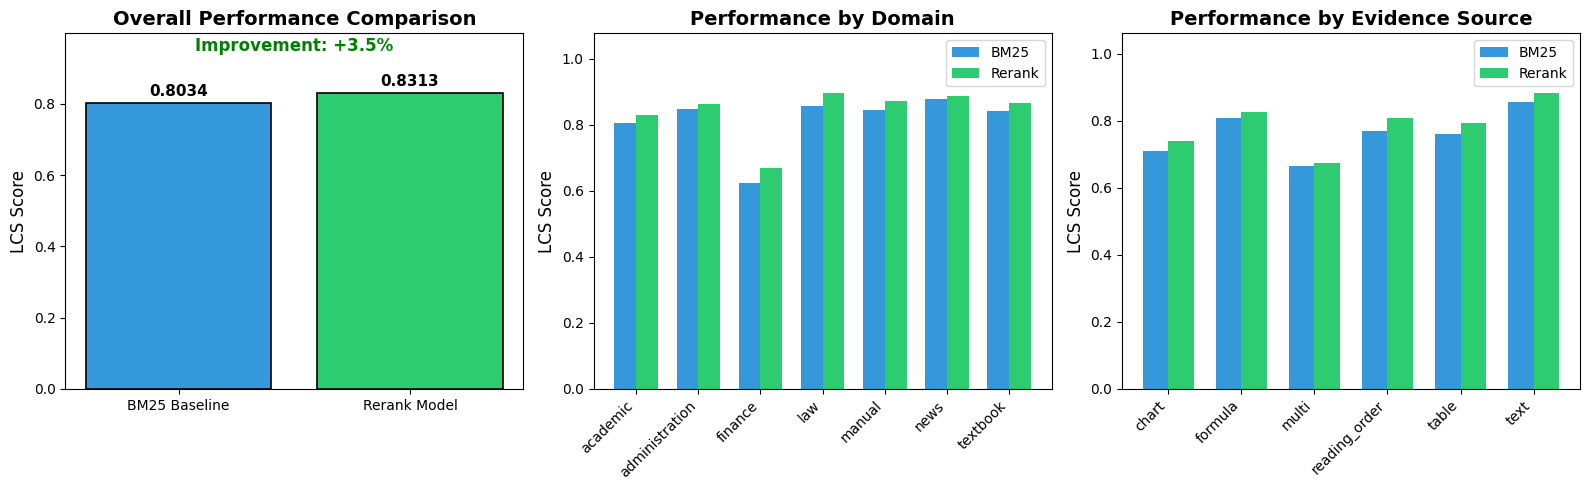


Visualization saved to output/comparison_visualization.png


In [25]:
# Visualization: BM25 vs Rerank Comparison
import matplotlib.pyplot as plt

# Load baseline scores for comparison
bm25_baseline_df = pd.read_csv(f'{OUTPUT_PATH}/bm25_baseline_scores.csv')
baseline_lcs = bm25_baseline_df['score'].mean()
rerank_lcs = rerank_df['score'].mean()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Overall Comparison Bar Chart
ax1 = axes[0]
methods = ['BM25 Baseline', 'Rerank Model']
scores = [baseline_lcs, rerank_lcs]
colors = ['#3498db', '#2ecc71']
bars = ax1.bar(methods, scores, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('LCS Score', fontsize=12)
ax1.set_title('Overall Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(scores) * 1.2)
for bar, score in zip(bars, scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
improvement = (rerank_lcs - baseline_lcs) / baseline_lcs * 100
ax1.text(0.5, 0.95, f'Improvement: {improvement:+.1f}%', transform=ax1.transAxes, 
         ha='center', fontsize=12, color='green' if improvement > 0 else 'red', fontweight='bold')

# 2. Comparison by Domain
ax2 = axes[1]
bm25_by_domain = bm25_baseline_df.groupby('domain')['score'].mean()
rerank_by_domain = rerank_df.groupby('domain')['score'].mean()
domains = sorted(set(bm25_by_domain.index) & set(rerank_by_domain.index))
x = np.arange(len(domains))
width = 0.35
bars1 = ax2.bar(x - width/2, [bm25_by_domain.get(d, 0) for d in domains], width, label='BM25', color='#3498db')
bars2 = ax2.bar(x + width/2, [rerank_by_domain.get(d, 0) for d in domains], width, label='Rerank', color='#2ecc71')
ax2.set_ylabel('LCS Score', fontsize=12)
ax2.set_title('Performance by Domain', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(domains, rotation=45, ha='right')
ax2.legend()
ax2.set_ylim(0, max(max(bm25_by_domain), max(rerank_by_domain)) * 1.2)

# 3. Comparison by Evidence Source
ax3 = axes[2]
bm25_by_evidence = bm25_baseline_df.groupby('evidence_source')['score'].mean()
rerank_by_evidence = rerank_df.groupby('evidence_source')['score'].mean()
evidence_types = sorted(set(bm25_by_evidence.index) & set(rerank_by_evidence.index))
x = np.arange(len(evidence_types))
bars1 = ax3.bar(x - width/2, [bm25_by_evidence.get(e, 0) for e in evidence_types], width, label='BM25', color='#3498db')
bars2 = ax3.bar(x + width/2, [rerank_by_evidence.get(e, 0) for e in evidence_types], width, label='Rerank', color='#2ecc71')
ax3.set_ylabel('LCS Score', fontsize=12)
ax3.set_title('Performance by Evidence Source', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(evidence_types, rotation=45, ha='right')
ax3.legend()
ax3.set_ylim(0, max(max(bm25_by_evidence), max(rerank_by_evidence)) * 1.2)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/comparison_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to {OUTPUT_PATH}/comparison_visualization.png")

In [26]:
# Save enhanced model
MODEL_OUTPUT_PATH = f'{OUTPUT_PATH}/model_enhanced'
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)

with open(f'{MODEL_OUTPUT_PATH}/rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

config = {
    'candidate_k': CANDIDATE_K, 
    'final_k': FINAL_K, 
    'n_estimators': N_ESTIMATORS, 
    'max_depth': MAX_DEPTH,
    'num_features': len(FEATURE_NAMES),
    'feature_names': FEATURE_NAMES
}
with open(f'{MODEL_OUTPUT_PATH}/config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f"Enhanced model saved to {MODEL_OUTPUT_PATH}/")
print(f"Model trained with {len(FEATURE_NAMES)} features")

Enhanced model saved to output/model_enhanced/
Model trained with 26 features
